In [1]:
import cv2 as cv2
import numpy as np
import pickle 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras as kr
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

ModuleNotFoundError: No module named 'cv2'

In [2]:
count = 0
for root, folders, filenames in os.walk('/kaggle/input'):
   print(root, folders)

In [3]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\ENG ABDO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [7]:
train_ds = kr.utils.image_dataset_from_directory(
    "E:/Covid19-dataset/train",  # Update the path to match the actual location of your training dataset
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = kr.utils.image_dataset_from_directory(
    "E:/Covid19-dataset/test", 
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


In [8]:
pip install math

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math
You should consider upgrading via the 'c:\Users\ENG ABDO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


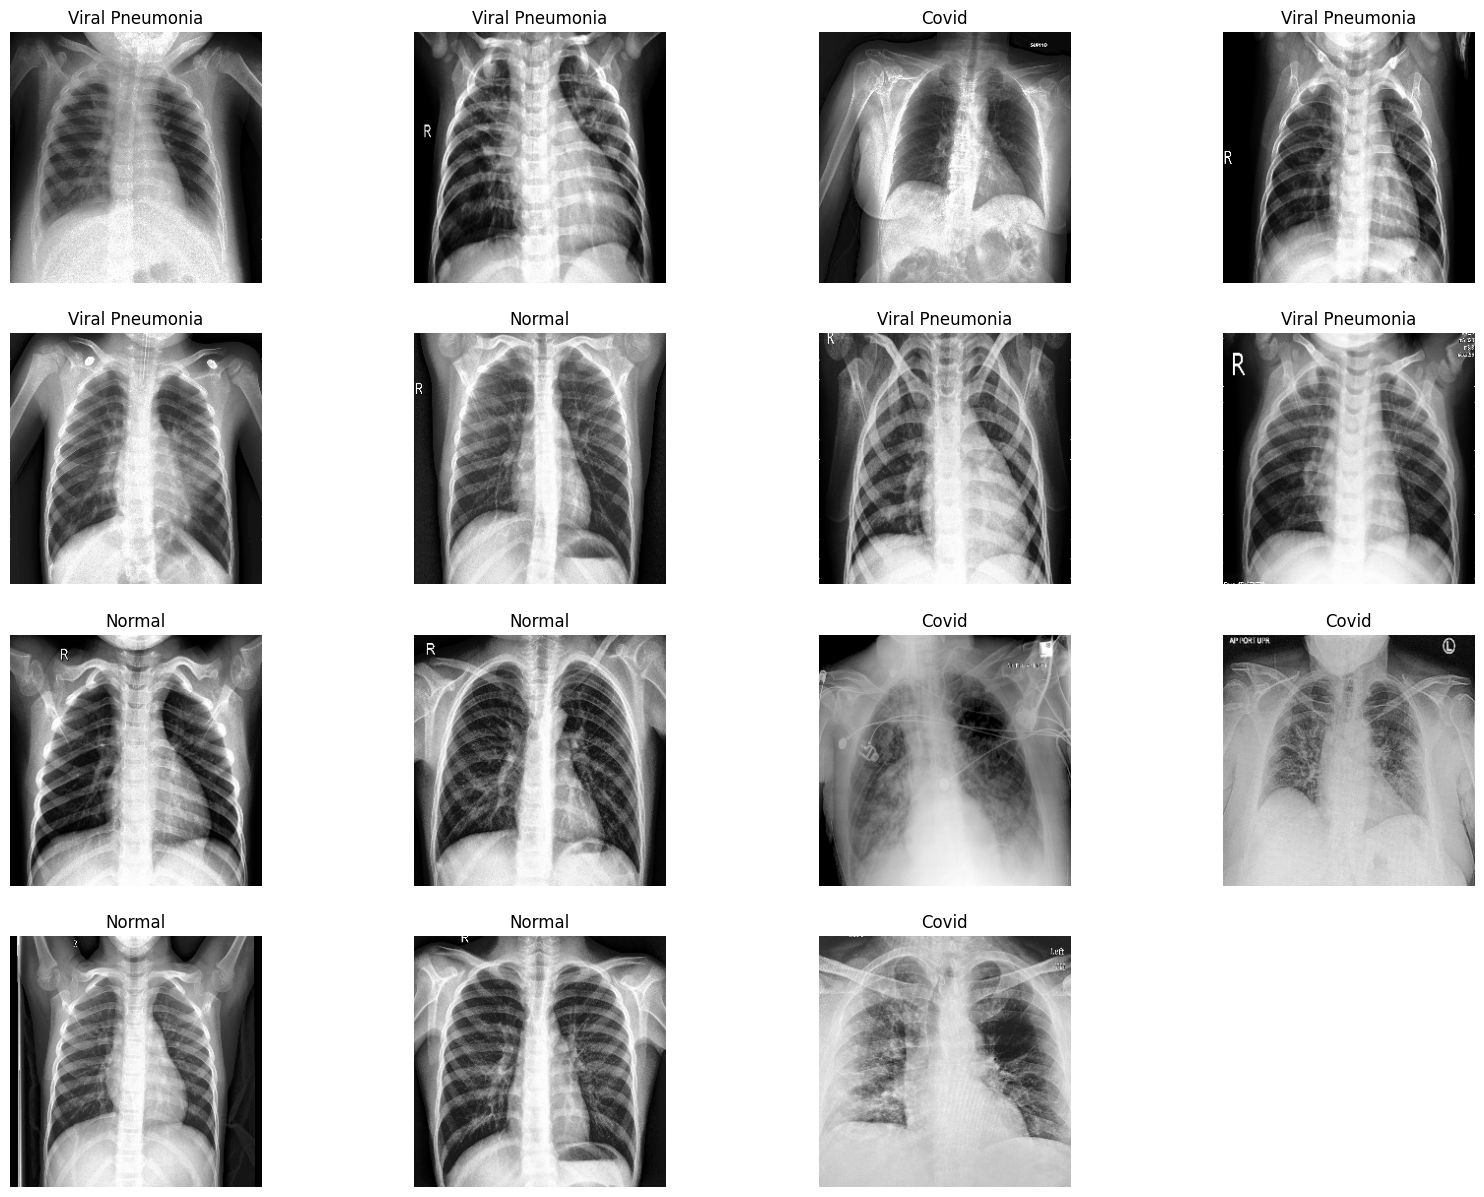

In [9]:
import math
def image_plot(generator,image_numbers):
    sample = generator.take(image_numbers)

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        image,img_label = sample.take(1).get_single_element()

        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(image/255)
        plt.title("Covid" if img_label == 0 else "Normal" if img_label== 1 else "Viral Pneumonia")
        plt.axis("off")

image_plot(train_ds.unbatch(),15)

In [10]:
class_names = train_ds.class_names
class_names

['Covid', 'Normal', 'Viral Pneumonia']

In [11]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  class_2 = labels == 2
  class_2 = tf.cast(class_0, tf.int32)
  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)
  counts['class_2'] += tf.reduce_sum(class_2)

  return counts

counts = train_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0, 'class_2' : 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy(),
                   counts['class_2'].numpy()]).astype(np.float32)
fractions = counts/counts.sum()
print(fractions)

[0.380137   0.23972602 0.380137  ]


In [12]:
def class_func(features, label):
  return label

In [13]:
resample_ds = (
    train_ds
    .unbatch()
    .rejection_resample(class_func, target_dist=[0.33,0.33,0.33],
                        initial_dist=fractions)
    .batch(32))

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [14]:
balanced_train_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [16]:
from keras.layers import Rescaling,Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Input
num_classes = 3

model = tf.keras.Sequential([
    Rescaling(1./255),
    Conv2D(32,3,activation = "relu"),
    MaxPooling2D(),
    Conv2D(32,3,activation = "relu"),
    MaxPooling2D(),
    Conv2D(32,3,activation = "relu"),
    MaxPooling2D(),
    Conv2D(32,3,activation = "relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(256,activation = 'relu'),
    Dropout(0.3),
    Dense(256,activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes,activation="softmax")
]
)
print("done")



done


In [17]:
optimzer = kr.optimizers.Adam(learning_rate=0.000001)
model.compile(
    optimizer="Adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
#early_stop = EarlyStopping(monitor='val_loss', patience=3)
model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    #callbacks=[early_stop],
    shuffle=True
)


Epoch 1/50


8/8 [==============================] - 7s 564ms/step - loss: 1.0964 - accuracy: 0.4741 - val_loss: 1.0339 - val_accuracy: 0.6515
Epoch 2/50
8/8 [==============================] - 3s 360ms/step - loss: 0.9224 - accuracy: 0.6175 - val_loss: 0.5886 - val_accuracy: 0.7576
Epoch 3/50
8/8 [==============================] - 3s 372ms/step - loss: 0.4588 - accuracy: 0.8247 - val_loss: 0.7045 - val_accuracy: 0.6515
Epoch 4/50
8/8 [==============================] - 3s 374ms/step - loss: 0.3951 - accuracy: 0.8406 - val_loss: 0.5758 - val_accuracy: 0.6667
Epoch 5/50
8/8 [==============================] - 3s 367ms/step - loss: 0.3257 - accuracy: 0.8725 - val_loss: 0.3079 - val_accuracy: 0.8485
Epoch 6/50
8/8 [==============================] - 3s 381ms/step - loss: 0.2715 - accuracy: 0.9004 - val_loss: 0.1960 - val_accuracy: 0.9242
Epoch 7/50
8/8 [==============================] - 3s 400ms/step - loss: 0.1662 - accuracy: 0.9402 - val_loss: 0.2770 - val_accuracy: 0.8788
Epoch 8/50
8/8 [=

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9

In [20]:
pip install sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [22]:
pip install scikit-learn

You should consider upgrading via the 'c:\Users\ENG ABDO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.



     -------------------------------------- 10.6/10.6 MB 150.5 kB/s eta 0:00:00
     --------------------------------------- 46.2/46.2 MB 69.7 kB/s eta 0:00:00
     ------------------------------------ 302.2/302.2 KB 207.7 kB/s eta 0:00:00


3/3 [==============================] - 0s 50ms/step


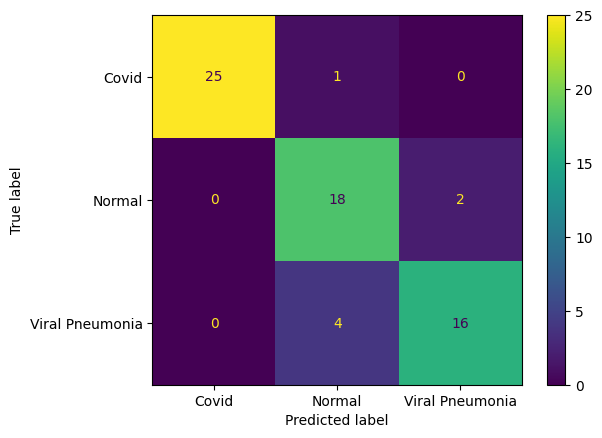

In [23]:
y_pred = np.argmax(model.predict(val_ds),axis=1)

train_label = np.concatenate([y for x, y in val_ds], axis=0)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 

CM = tf.math.confusion_matrix(labels=test_label,predictions=y_pred).numpy()

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cd = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = class_names)
cd.plot()
plt.show()

In [24]:
outputs = [layer.output for layer in model.layers[8:8]]

# Define a new model that generates the above output
vis_model = kr.models.Model(model.input, [model.layers[5].output,model.output])
print(model.layers[3].name)
# check if we have all the layers we require for visualization 
vis_model.summary()

conv2d_1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_input (InputLaye  [(None, 256, 256, 3)]     0         
 r)                                                              
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)     

In [25]:
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

Layers going to be used for visualization: 
[]


In [26]:
from keras import backend as K
def get_CAM(processed_image, predicted_label):
    with tf.GradientTape() as gtape:
        data = vis_model(processed_image)
        conv_output = data[0]
        print(conv_output.shape)
        predictions = data[1]
        loss = predictions[:, np.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        print(grads.shape)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = np.squeeze(tf.multiply(pooled_grads, conv_output))
    print(f"max before mean : {np.max(heatmap)}")
    heatmap = tf.reduce_mean(np.abs(heatmap), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    return heatmap
def show_random_sample(idx):
    sample = val_ds.unbatch().shuffle(64).take(1)
    image,label = sample.get_single_element()
    image = image.numpy()
    label = label.numpy()
    sample_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample_label = label
    
    # pre-process the image
    sample_image_processed = np.expand_dims(sample_image,axis=0)
    print(sample_image.shape)
    # generate activation maps from the intermediate layers using the visualization model
    activations = vis_model.predict(sample_image_processed)
    # get the label predicted by our original model
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
 # choose any random activation map from the activation maps 
    print('acti')
    print(activations[0].shape)
    sample_activation = activations[0][0,:,:,31]
    
    # normalize the sample activation map
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    # convert pixel values between 0-255
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    heatmap = get_CAM(sample_image_processed, pred_label)
    print(heatmap.shape)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    print(f"max : {np.max(heatmap)}")
    heatmap = heatmap/np.max(heatmap)*255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    print(heatmap.shape)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    super_imposed_image = heatmap * 0.5 + sample_image
    super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)

    f,ax = plt.subplots(2,2, figsize=(15,8))
    ax[0,0].imshow(sample_image/255)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.show()
    
    return activations

(256, 256, 3)
1/1 [==============================] - 0s 79ms/step
acti
(1, 60, 60, 32)
(1, 60, 60, 32)
(1, 60, 60, 32)
max before mean : 4.2578145453830984e-09
(60, 60)
max : 2.2048070036362333e-09
(256, 256)


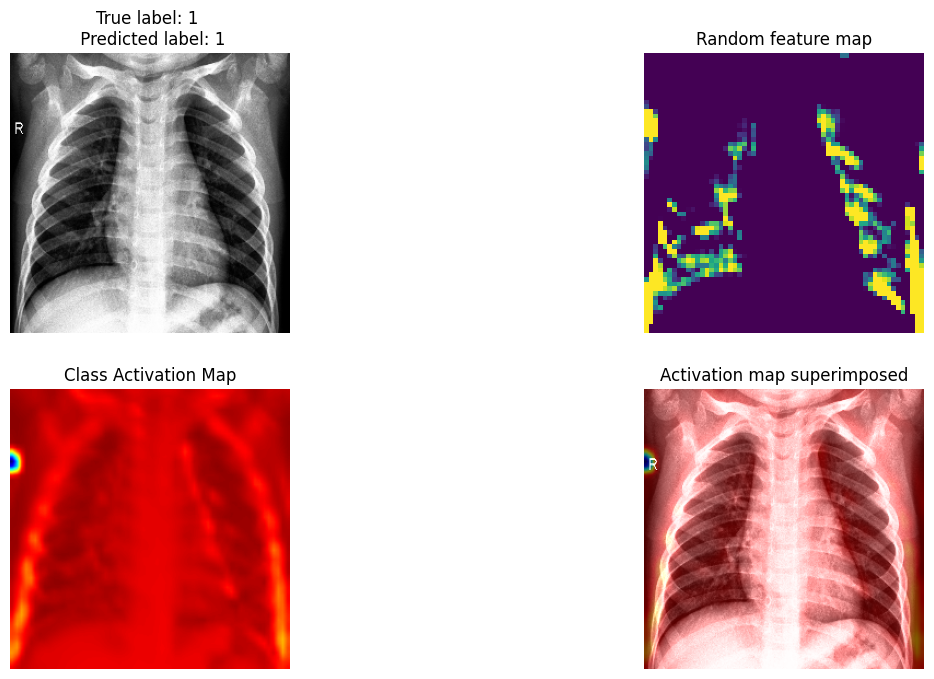

In [27]:
activations= show_random_sample(123)

In [28]:
def visualize_intermediate_activations(layer_names, activations):
    """
    This function is used to visualize all the itermediate activation maps
    
    Arguments:
        layer_names: list of names of all the intermediate layers we chose
        activations: all the intermediate activation maps 
    """
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=2
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size * 6
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()